## Working with Raster data

In [1]:
import numpy as np
import rasterio

In [2]:
df = rasterio.open(r"..\data\geotiff\nepal_lc_2020.tif")
data = df.read()
print(f"Numpy aray of data:\n {data}")

Numpy aray of data:
 [[[255 255 255 ... 255 255 255]
  [255 255 255 ... 255 255 255]
  [255 255 255 ... 255 255 255]
  ...
  [255 255 255 ... 255 255 255]
  [255 255 255 ... 255 255 255]
  [255 255 255 ... 255 255 255]]]


In [3]:
metadata = df.meta
height = df.height
width = df.width
crs = df.crs
driver = df.driver
bands = df.count
transform = df.transform
description = df.descriptions

print(f" Height: {height}\n Width: {width}\n CRS: {crs}\n Driver: {driver}\n No. of bands: {bands}\n Transformation: {transform}\n Metadata: {metadata}\n Description: {description}")


 Height: 1485
 Width: 2932
 CRS: EPSG:4326
 Driver: GTiff
 No. of bands: 1
 Transformation: | 0.00, 0.00, 80.06|
| 0.00,-0.00, 30.47|
| 0.00, 0.00, 1.00|
 Metadata: {'driver': 'GTiff', 'dtype': 'uint8', 'nodata': 255.0, 'width': 2932, 'height': 1485, 'count': 1, 'crs': CRS.from_wkt('GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]'), 'transform': Affine(0.0027777777777780012, 0.0, 80.05847091000004,
       0.0, -0.0027777777777780012, 30.472819010000357)}
 Description: (None,)


In [4]:
size = data.size
shape = data.shape

print(f" Numpy array size: {size}\n Numpy array shape: {shape}")

 Numpy array size: 4354020
 Numpy array shape: (1, 1485, 2932)


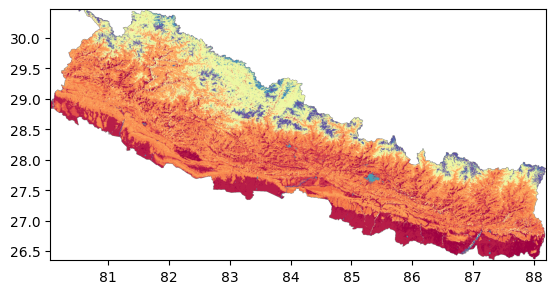

<Axes: >

In [5]:
from rasterio.plot import show
import matplotlib

show(df, transform = transform, cmap = 'Spectral')

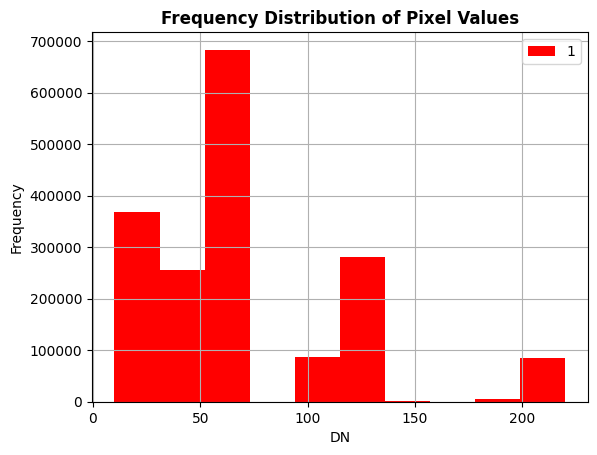

In [6]:
from rasterio.plot import show_hist
show_hist(df, title = "Frequency Distribution of Pixel Values")

In [7]:
# Masking the raster to focus on Pokhara region
import fiona 
import rasterio.mask

with fiona.open(r"..\data\shp\pokhara.shp",
                 "r") as shapefile:
    shapes = [feature["geometry"] for feature in shapefile]

with rasterio.open(r"..\data\geotiff\nepal_lc_2020.tif") as src:
    out_image, out_transform = rasterio.mask.mask(src, shapes, crop = True)
    out_meta = src.meta

out_meta.update({"driver": "GTiff",
                "height": out_image.shape[1],
                "width": out_image.shape[2],
                "transform": out_transform})

# Write
with rasterio.open(r"..\data\geotiff\pokhara-mask.tif", "w", **out_meta) as dest:
    dest.write(out_image)

In [8]:
df_pokhra = rasterio.open(r"..\data\geotiff\pokhara-mask.tif")

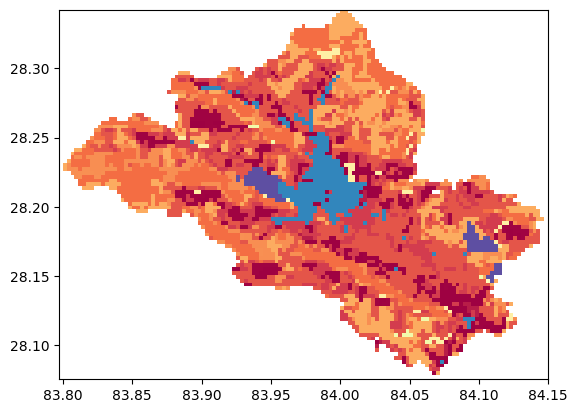

<Axes: >

In [9]:
show(df_pokhra, transform=df_pokhra.transform, cmap = "Spectral")

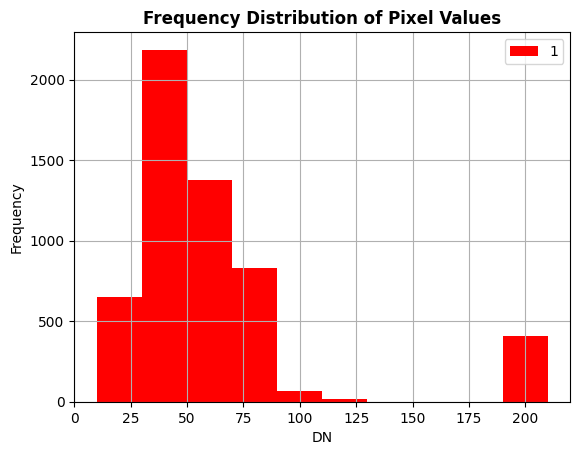

In [10]:
show_hist(df_pokhra, title = "Frequency Distribution of Pixel Values")

## Mathematical Operations with Raster Data

In [12]:
data = data + 1
print(f"Adding 1 to each pixel value: {data}")

data = data *2
print(f"Multiplying 2 with each pixel value: {data}")

# Saving and printing
with rasterio.open(r"..\data\geotiff\nepal-new.tif", "w", 
                   driver = df.driver,
                   width = df.width,
                   height = df.height,
                   count = df.count,
                   dtype = data.dtype,
                   crs = df.crs,
                   transform = df.transform) as dst:
    dst.write(data)

Adding 1 to each pixel value: [[[1 1 1 ... 1 1 1]
  [1 1 1 ... 1 1 1]
  [1 1 1 ... 1 1 1]
  ...
  [1 1 1 ... 1 1 1]
  [1 1 1 ... 1 1 1]
  [1 1 1 ... 1 1 1]]]
Multiplying 2 with each pixel value: [[[2 2 2 ... 2 2 2]
  [2 2 2 ... 2 2 2]
  [2 2 2 ... 2 2 2]
  ...
  [2 2 2 ... 2 2 2]
  [2 2 2 ... 2 2 2]
  [2 2 2 ... 2 2 2]]]


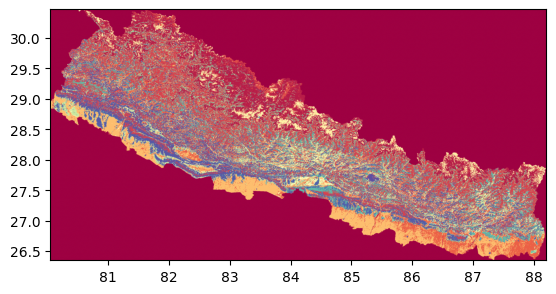

<Axes: >

In [15]:
df_new = rasterio.open(r"..\data\geotiff\nepal-new.tif")
show(df_new, transform = df_new.transform, cmap = "Spectral")

### Reclassification

In [17]:
lista = data.copy()

lista[np.where((lista >=10) & (lista <= 40))] = 1 # Agriculture
lista[np.where((lista >=50) & (lista <= 100))] = 2 # Forest
lista[np.where((lista >=110) & (lista <= 180))] = 3 # grass land
lista[np.where(lista >=190 )] = 4 #urban
lista[np.where(lista >=200)] = 5 #bareland
lista[np.where((lista >=210) & (lista <= 200))] = 6 #Water


with rasterio.open(r"..\data\geotiff\nepal-reclassify.tif", "w",
                   driver=df.driver,
                   height=df.height,
                   width=df.width,
                   count=df.count,
                   crs=df.crs,
                   transform=df.transform,
                   dtype=data.dtype

) as dst:
      dst.write(lista)

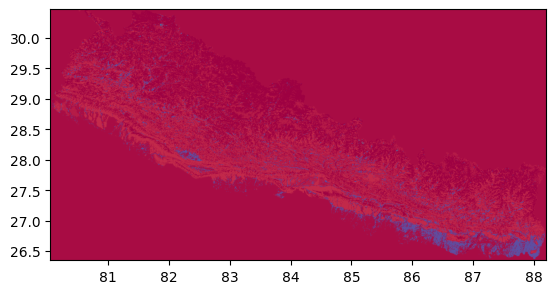

<Axes: >

In [18]:
df_new = rasterio.open(r"..\data\geotiff\nepal-reclassify.tif")
show(df_new, transform = df_new.transform, cmap = "Spectral")

### NDVI

In [ ]:

img_red = r"..\data\geotiff\MODIS_18Dec17_NIR.tif"
img_nir = r"..\data\geotiff\MODIS_18Dec17_RED.tif"

with rasterio.open(img_nir) as ds_nir, rasterio.open(img_red) as ds_red:

    data_nir = ds_nir.read(1).astype('float64')
    data_red = ds_red.read(1).astype('float64')
    
    denominator = data_nir + data_red
    numerator = data_nir - data_red

    data_NDVI = np.divide(numerator, denominator, 
                          out=np.zeros_like(data_nir), 
                          where=denominator != 0)

    meta = ds_nir.meta.copy()
    meta.update({
        "driver": "GTiff",
        "dtype": "float64",
        "count": 1,
        "transform": ds_nir.transform 
    })

    with rasterio.open(r"..\data\geotiff\nepal-ndvi.tif", 'w', **meta) as dst:
        dst.write(data_NDVI, 1)

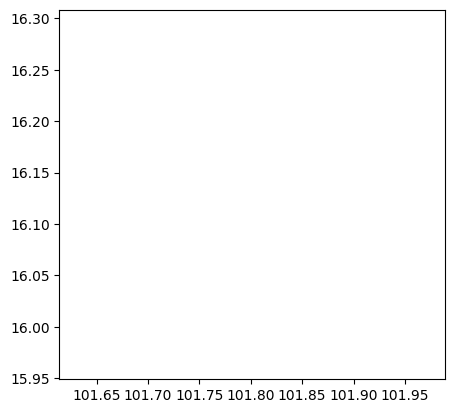

<Axes: >

In [22]:
df_new = rasterio.open(r"..\data\geotiff\nepal-ndvi.tif")
show(df_new, transform = df_new.transform, cmap = "Spectral")